In [1]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

2022-07-14 20:43:49.253452: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-07-14 20:43:49.280708: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:43:49.312705: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:43:49.312860: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 6000418441126128206
 xla_global_id: -1,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 6019153920
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1332840853387965986
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:2b:00.0, compute capability: 8.6"
 xla_global_id: 416903419]

In [2]:
# import sys
# log_path = 'log.txt'
# sys.stdout = open(log_path, "w")

import h5py
h5 = h5py.File('./data/test_5_1_07112022.hdf5', mode='r')
dataset = h5.get('phi')

data_sz = dataset.shape[0]
indexes = np.arange(data_sz)
np.random.shuffle(indexes)
train_index = np.sort(indexes[: int(0.75 * data_sz)])
val_index = np.sort(indexes[int(0.75 * data_sz) :])

print(f'Dataset shape is: {dataset.shape}')
train_dataset = np.take(dataset,train_index,axis=0)
val_dataset = np.take(dataset,val_index,axis=0)
print(f'Splitted trainning dataset shape is: {train_dataset.shape}')
print(f'Splitted trainning dataset shape is: {val_dataset.shape}')

Dataset shape is: (92, 69, 100, 100, 6)
Splitted trainning dataset shape is: (69, 69, 100, 100, 6)
Splitted trainning dataset shape is: (23, 69, 100, 100, 6)


In [3]:
from tqdm import tqdm

def create_shifted_frames_5to1(dataset):
    numFrames = 5
    sz = dataset.shape[0]*(dataset.shape[1]-5)
    x = np.zeros([sz, numFrames, 100, 100, 5])
    y = np.zeros([sz, 2, 100, 100, 5])
    k = 0
    for i in tqdm(range(dataset.shape[0]), desc="Running ..."):
        for j in range(dataset.shape[1]-numFrames):
            currentFrame = np.expand_dims(np.expand_dims(dataset[i,j+numFrames,:,:,0:5],axis=0),axis=0)
            pastFrames = np.expand_dims(dataset[i,j:(j+numFrames),:,:,0:5],axis=0)
            x[k,...] = pastFrames
            y[k,0,...] = currentFrame
            y[k,1,...] = pastFrames[:,-1,...] # passing past frame to ground truth for use in loss function
            k+=1  
    return x,y

x_train, y_train = create_shifted_frames_5to1(train_dataset)
x_val, y_val = create_shifted_frames_5to1(val_dataset)

x_train[...,2] = x_train[...,2]*10
y_train[...,2] = y_train[...,2]*10
x_val[...,2] = x_val[...,2]*10
y_val[...,2] = y_val[...,2]*10

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

# some wierd memory issue with tensorflow, same batch size with smaller dataset size works
x_train = np.take(x_train,np.arange(3000),axis=0)
y_train = np.take(y_train,np.arange(3000),axis=0)
x_val = np.take(x_val,np.arange(1000),axis=0)
y_val = np.take(y_val,np.arange(1000),axis=0)

print("Training Dataset Shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("Validation Dataset Shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

Running ...: 100%|██████████| 23/23 [00:01<00:00, 20.71it/s]


Training Dataset Shapes: (4416, 5, 100, 100, 5), (4416, 2, 100, 100, 5)
Validation Dataset Shapes: (1472, 5, 100, 100, 5), (1472, 2, 100, 100, 5)
Training Dataset Shapes: (3000, 5, 100, 100, 5), (3000, 2, 100, 100, 5)
Validation Dataset Shapes: (1000, 5, 100, 100, 5), (1000, 2, 100, 100, 5)


(3000, 5, 100, 100, 5)
2004


Text(0.5, 1.0, 'Frame 5')

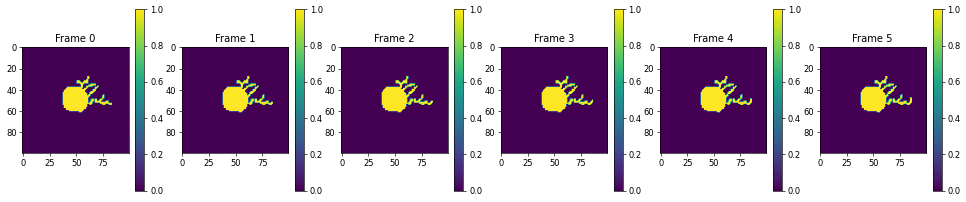

In [4]:
print(x_train.shape)
data_choice = np.random.choice(range(len(x_train)), size=1)[0]
print(data_choice)
channel = 0
plt.figure(figsize=(20, 4), dpi=60)
plt.subplot(1,6,1)
plt.imshow(x_train[data_choice,0,:,:,channel])
plt.colorbar()
plt.title("Frame 0")
plt.subplot(1,6,2)
plt.imshow(x_train[data_choice,1,:,:,channel])
plt.colorbar()
plt.title("Frame 1")
plt.subplot(1,6,3)
plt.imshow(x_train[data_choice,2,:,:,channel])
plt.colorbar()
plt.title("Frame 2")
plt.subplot(1,6,4)
plt.imshow(x_train[data_choice,3,:,:,channel])
plt.colorbar()
plt.title("Frame 3")
plt.subplot(1,6,5)
plt.imshow(x_train[data_choice,4,:,:,channel])
plt.colorbar()
plt.title("Frame 4")
plt.subplot(1,6,6)
plt.imshow(y_train[data_choice,0,:,:,channel])
plt.colorbar()
plt.title("Frame 5")


In [5]:
def get_deriv(input):
    N1N_input, NN1_input = tf.image.image_gradients(input)
    N2N_input, _ = tf.image.image_gradients(N1N_input)
    _, NN2_input = tf.image.image_gradients(NN1_input)
    LAP_input = tf.math.add(N2N_input,NN2_input)
    return N1N_input, NN1_input, N2N_input, NN2_input, LAP_input

def get_MSE_tf(input,goal):
    return tf.math.reduce_mean(tf.square(tf.math.subtract(input, goal)))

def PINN_loss():
    def loss(y_true, y_pred):
        dt = 0.01*500 # current data sampled per 500 iter (change based on dataset)
        
        true_phi = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,0],axis=0),axis=3), dtype=tf.float64)
        true_tub = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,2],axis=0),axis=3), dtype=tf.float64)
        true_tempr = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,0,:,:,3],axis=0),axis=3), dtype=tf.float64)

        NN_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,2],axis=0),axis=3), dtype=tf.float64)
        tempr_p = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,3],axis=0),axis=3), dtype=tf.float64)
        theta = tf.cast(tf.expand_dims(tf.expand_dims(y_true[0,1,:,:,4],axis=0),axis=3), dtype=tf.float64) # Since theta is passed, theta remains the same

        NN_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,0],axis=0),axis=3), dtype=tf.float64)
        tub_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,2],axis=0),axis=3), dtype=tf.float64)
        tempr_pK = tf.cast(tf.expand_dims(tf.expand_dims(y_pred[0,-1,:,:,3],axis=0),axis=3), dtype=tf.float64)

        N1N_p, NN1_p, _, _, LAP_p = get_deriv(NN_p)
        N1N_theta, NN1_theta, _, _, _ = get_deriv(theta)
        _, _, _, _, LAP_tp = get_deriv(tempr_p)
        N1N_tb, NN1_tb, _, _, LAP_tb = get_deriv(tub_p)

        # Temperature residual
        tempr_residual = (3*LAP_tp+4*(NN_pK - NN_p)/dt)*dt + tempr_p - tempr_pK

        # Tubulin residual
        diff_tb = 4*(tf.math.multiply(N1N_p,N1N_tb) + tf.math.multiply(NN1_p,NN1_tb) + tf.math.multiply(NN_p,LAP_tb))
        alph_tb = 0.001*(tf.math.multiply(N1N_p,tub_p) + tf.math.multiply(NN_p,N1N_tb) + tf.math.multiply(NN1_p,tub_p) + tf.math.multiply(NN_p,NN1_tb))
        beta_tb = 0.001*tf.math.multiply(NN_p,tub_p)
        src_tb = tf.math.divide_no_nan(15*tf.math.square(LAP_p),tf.math.reduce_sum(tf.math.square(LAP_p)))
        tub_residual = (diff_tb - alph_tb - beta_tb + src_tb)*dt + tub_p - tub_pK

        # Energy calculation
        e = 0.2865*tf.math.atan(10*tf.math.multiply(5*tub_pK-0.1,1-tempr_pK))

        # phase field residual
        atheta = tf.math.atan2(NN1_p,N1N_p)
        a = 0.04*(1.0+0.1*tf.math.cos(6*(atheta-theta)))
        ap = -0.04*(6*0.1*tf.math.sin(6*(atheta-theta)))
        aap = tf.math.multiply(a,ap)
        a2 = tf.math.square(a)
        a2Lap = tf.math.multiply(a2,LAP_p)
        N1N_aapNN1p, _ = tf.image.image_gradients(tf.math.multiply(aap,NN1_p))
        _, NN1_aapN1Np = tf.image.image_gradients(tf.math.multiply(aap,N1N_p))
        mag_theta = tf.math.sqrt(tf.math.square(N1N_theta) + tf.math.square(NN1_theta))
        dblwll_term = tf.math.multiply(tf.math.multiply(NN_p,1-NN_p),NN_p - 0.5 + e + 6*0.007*mag_theta)
        phi_residual = a2Lap - N1N_aapNN1p + NN1_aapN1Np + dblwll_term - (NN_pK - NN_p) / dt

        residual_mse = get_MSE_tf(phi_residual,0) + get_MSE_tf(tempr_residual,0) + get_MSE_tf(tub_residual,0)
        # diff_mse = get_MSE_tf(NN_pK,true_phi) + get_MSE_tf(tempr_pK,true_tempr) + get_MSE_tf(tub_pK,true_tub)
        diff_mse = get_MSE_tf(NN_pK,true_phi)
        loss = residual_mse + diff_mse
        
        return loss
    return loss

In [6]:
from tensorflow.keras import layers
inp = layers.Input(shape=(x_train.shape[1:]))

x0 = layers.TimeDistributed(layers.SeparableConv2D(
    filters=64,
    kernel_size=(5, 5),
    strides = (2, 2),
    depth_multiplier=1,
    padding="valid",
    activation="relu",
))(inp)
x1 = layers.TimeDistributed(layers.SeparableConv2D(
    filters=128,
    kernel_size=(5, 5),
    strides = (2, 2),
    depth_multiplier=1,
    padding="valid",
    activation="relu",
))(x0)
x2 = layers.ConvLSTM2D(
    filters=128,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=False,
    activation="relu",
    # recurrent_dropout=drop_rate,
)(x1)
x2 = tf.expand_dims(x2,axis=1)

# decoding for phi channel
phi1 = x2
phi2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(phi1)
phi3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="sigmoid",
))(phi2)

# decoding for tips channel
tip1 = phi3
tip2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="relu",
))(tip1)

# decoding for tublin channel
tub1 = x2
tub2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tub1)
tub3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tub2)
tub4 = tf.math.multiply(phi3,tub3)

# decoding for temperature channel
phi_pre = tf.expand_dims(tf.expand_dims(inp[:,-1,:,:,0],axis=1),axis=4)
phi_diff = phi3 - phi_pre
tempr1 = x2
tempr2 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=64,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tempr1)
tempr3 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (2, 2),
    padding="valid",
    activation="relu",
))(tempr2)
tempr3 = tf.concat([tempr3,phi_diff],axis=4)
tempr4 = layers.TimeDistributed(layers.Conv2DTranspose(
    filters=1,
    kernel_size=(6, 6),
    strides = (1, 1),
    padding="same",
    activation="relu",
))(tempr3)

# passing theta (no change)
theta1 = tf.expand_dims(tf.expand_dims(inp[:,0,:,:,-1],axis=1),axis=4)

out = tf.concat([phi3,tip2,tub4,tempr4,theta1],axis=4)

2022-07-14 20:44:21.768672: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:44:21.768850: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:44:21.768952: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:44:21.769208: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 20:44:21.769318: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from S

In [7]:
model = keras.models.Model(inp, out)
model.compile(
    # loss=keras.losses.MeanSquaredError(reduction="auto", name="mean_squared_error"),
    loss=PINN_loss(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-4))
print(model.summary())

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 5, 100, 100  0           []                               
                                , 5)]                                                             
                                                                                                  
 time_distributed (TimeDistribu  (None, 5, 48, 48, 6  509        ['input_1[0][0]']                
 ted)                           4)                                                                
                                                                                                  
 time_distributed_1 (TimeDistri  (None, 5, 22, 22, 1  9920       ['time_distributed[0][0]']       
 buted)                         28)                                                           

In [8]:
class CustomSaver(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if epoch == 10:  # or save after some epoch, each k-th epoch etc.
            self.model.save("model_{}.hd5".format(epoch))
            
test = False

if test == True:
    model = keras.models.load_model('./saved_model/model_conv_lstm_test_12')
else: 
    early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=20)
    reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=15)
    epochs = 1000
    batch_size = 4
    # saver = CustomSaver()
    with tf.device('/device:GPU:0'):
        model.fit(
            x_train,
            y_train,
            batch_size=batch_size,
            epochs=epochs,
            validation_data=(x_val, y_val),
            # callbacks=[saver,early_stopping, reduce_lr],
            callbacks=[early_stopping, reduce_lr],
        )

    model.save('./saved_model/model_conv_lstm_test_12') 

2022-07-14 20:44:22.836601: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3000000000 exceeds 10% of free system memory.
2022-07-14 20:44:24.733206: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 3000000000 exceeds 10% of free system memory.


Epoch 1/1000


2022-07-14 20:44:28.106464: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'Func/gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/input/_551' -> 'gradient_tape/model/conv_lstm2d/while/model/conv_lstm2d/while_grad/body/_189/gradient_tape/model/conv_lstm2d/while/gradients/AddN', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_3', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_6' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_4', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/clip_by_value_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5'}.
2022-07-14 20

749/750 [============================>.] - ETA: 0s - loss: 1.6046

2022-07-14 20:44:58.484500: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:903] layout failed: INVALID_ARGUMENT: MutableGraphView::SortTopologically error: detected edge(s) creating cycle(s) {'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_2' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/Relu_1' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/mul_5', 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/convolution_7' -> 'model/conv_lstm2d/while/body/_1/model/conv_lstm2d/while/add_6'}.


750/750 [==============================] - 35s 42ms/step - loss: 1.6041 - val_loss: 1.1010 - lr: 1.0000e-04
Epoch 2/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.8925 - val_loss: 0.8891 - lr: 1.0000e-04
Epoch 3/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.6779 - val_loss: 0.7300 - lr: 1.0000e-04
Epoch 4/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.4999 - val_loss: 0.6277 - lr: 1.0000e-04
Epoch 5/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.4134 - val_loss: 0.4450 - lr: 1.0000e-04
Epoch 6/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.3594 - val_loss: 0.4097 - lr: 1.0000e-04
Epoch 7/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.3406 - val_loss: 0.3989 - lr: 1.0000e-04
Epoch 8/1000
750/750 [==============================] - 30s 40ms/step - loss: 0.3137 - val_loss: 0.3718 - lr: 1.0000e-04
Epoch 9/1000
750/750 [=======================

INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_12/assets


INFO:tensorflow:Assets written to: ./saved_model/model_conv_lstm_test_12/assets


Plotting and Saving figures ...:   0%|          | 0/64 [00:00<?, ?it/s]

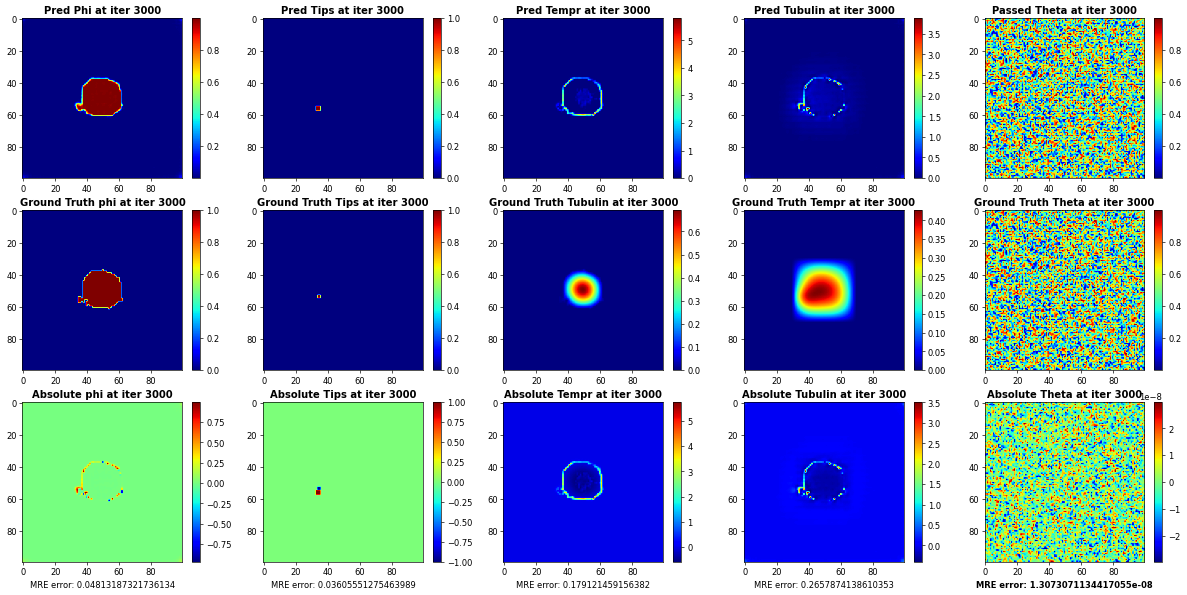

Plotting and Saving figures ...:   2%|▏         | 1/64 [00:02<02:33,  2.44s/it]

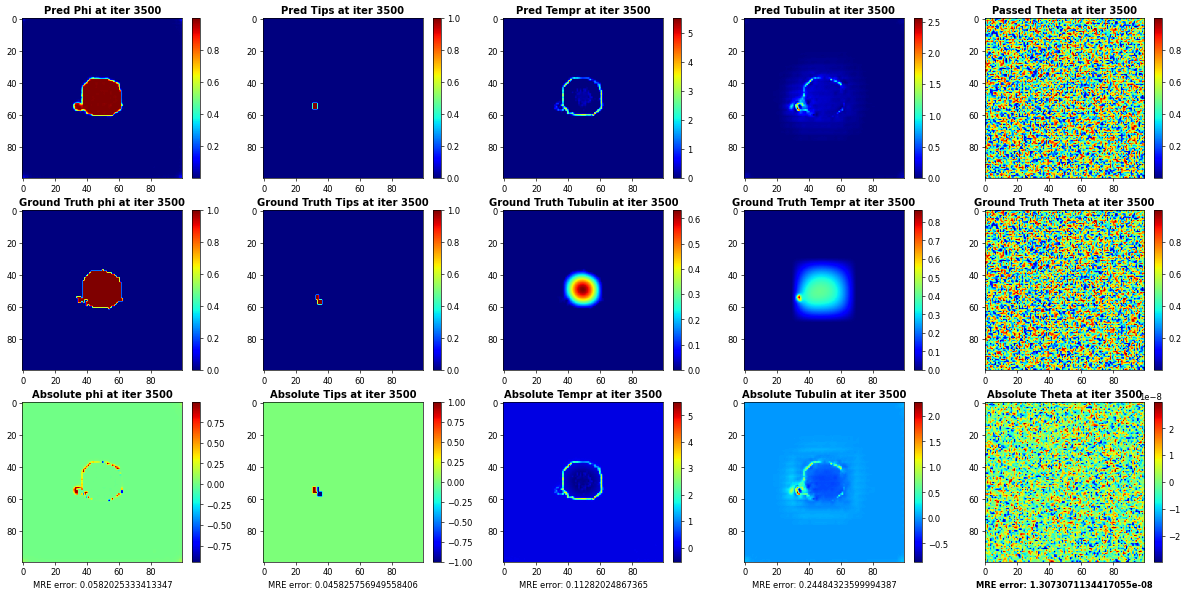

Plotting and Saving figures ...:   3%|▎         | 2/64 [00:03<01:50,  1.79s/it]

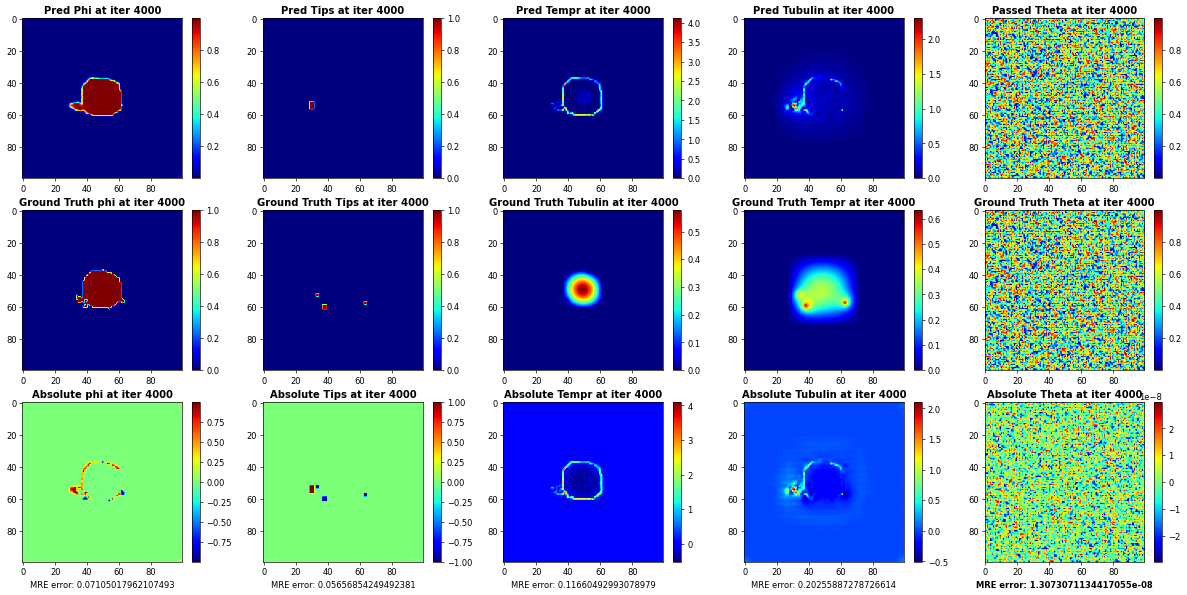

Plotting and Saving figures ...:   5%|▍         | 3/64 [00:05<01:43,  1.70s/it]

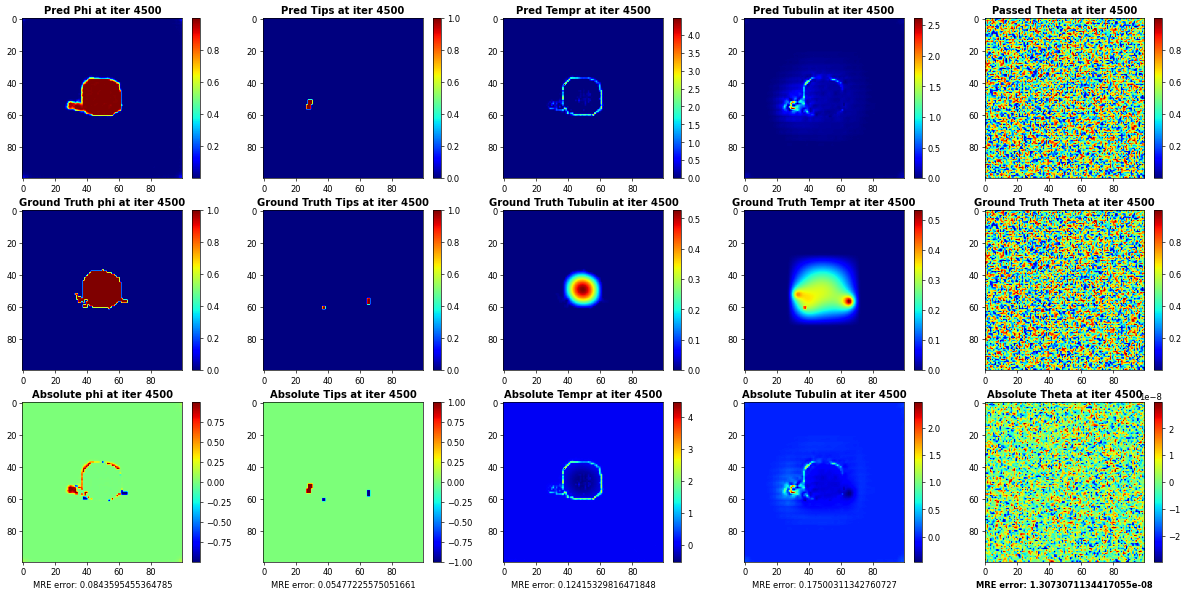

Plotting and Saving figures ...:   6%|▋         | 4/64 [00:06<01:32,  1.54s/it]

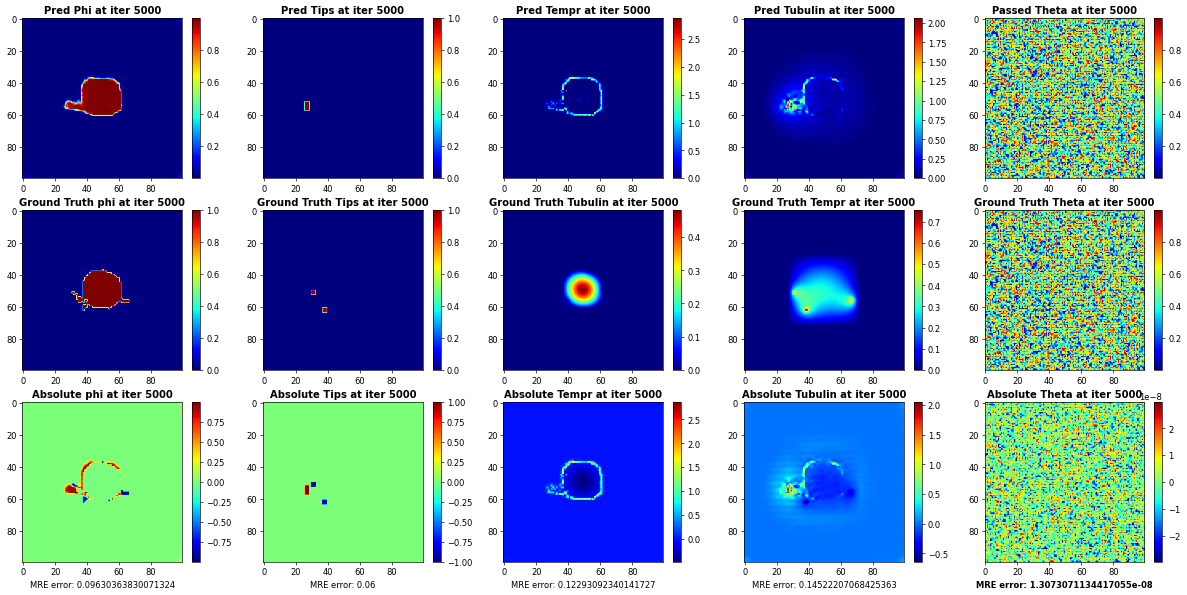

Plotting and Saving figures ...:   8%|▊         | 5/64 [00:08<01:26,  1.47s/it]

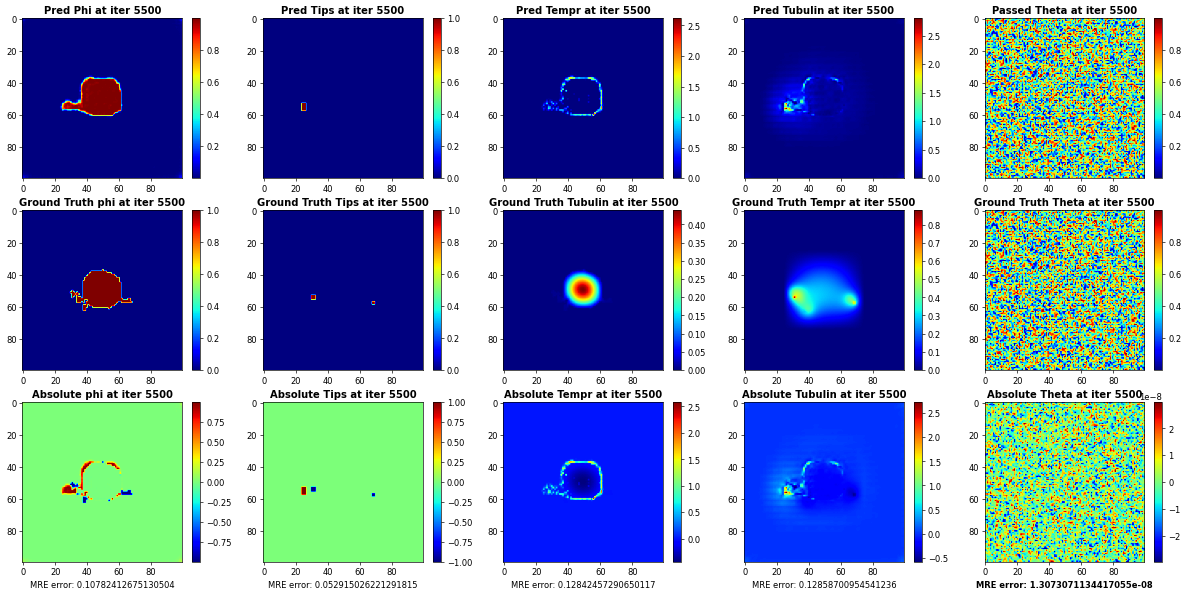

Plotting and Saving figures ...:   9%|▉         | 6/64 [00:09<01:28,  1.53s/it]

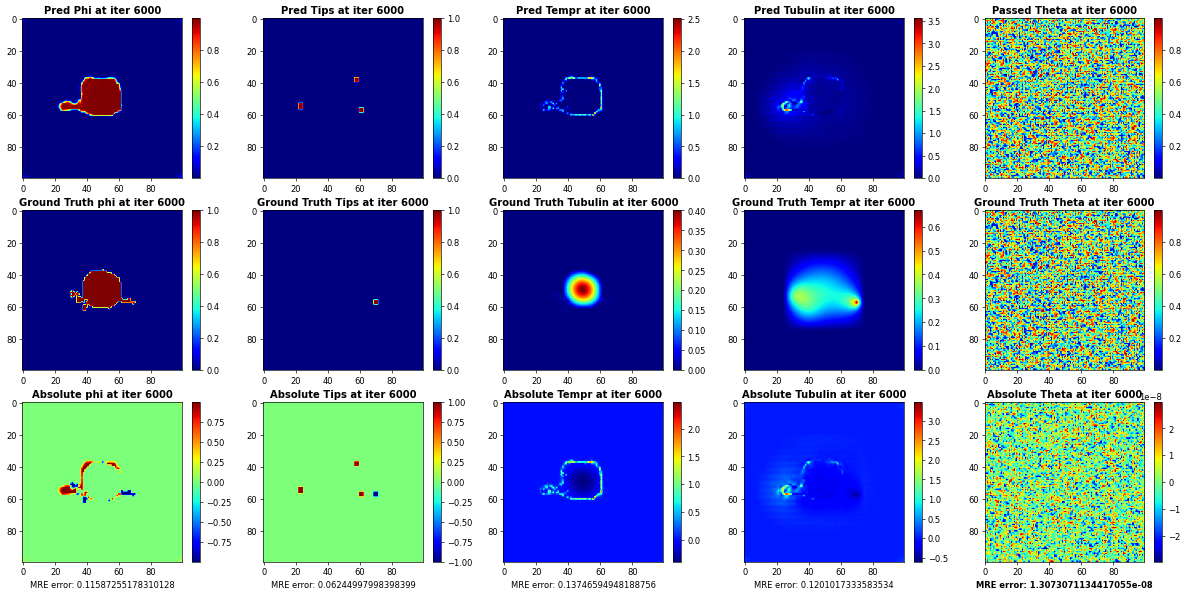

Plotting and Saving figures ...:  11%|█         | 7/64 [00:10<01:23,  1.47s/it]

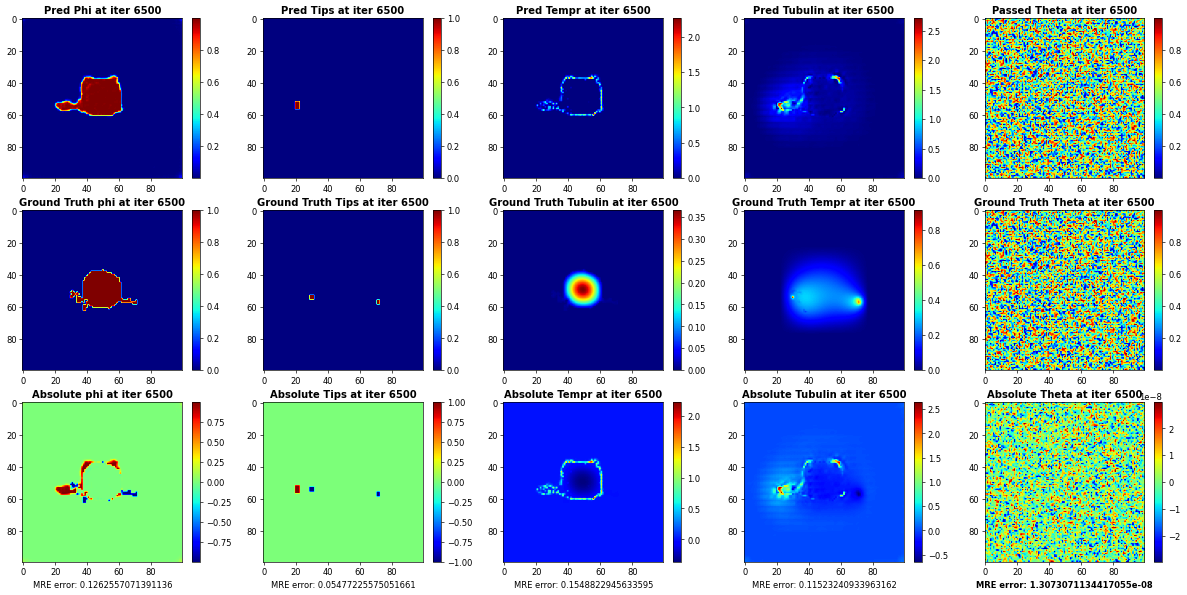

Plotting and Saving figures ...:  12%|█▎        | 8/64 [00:12<01:19,  1.42s/it]

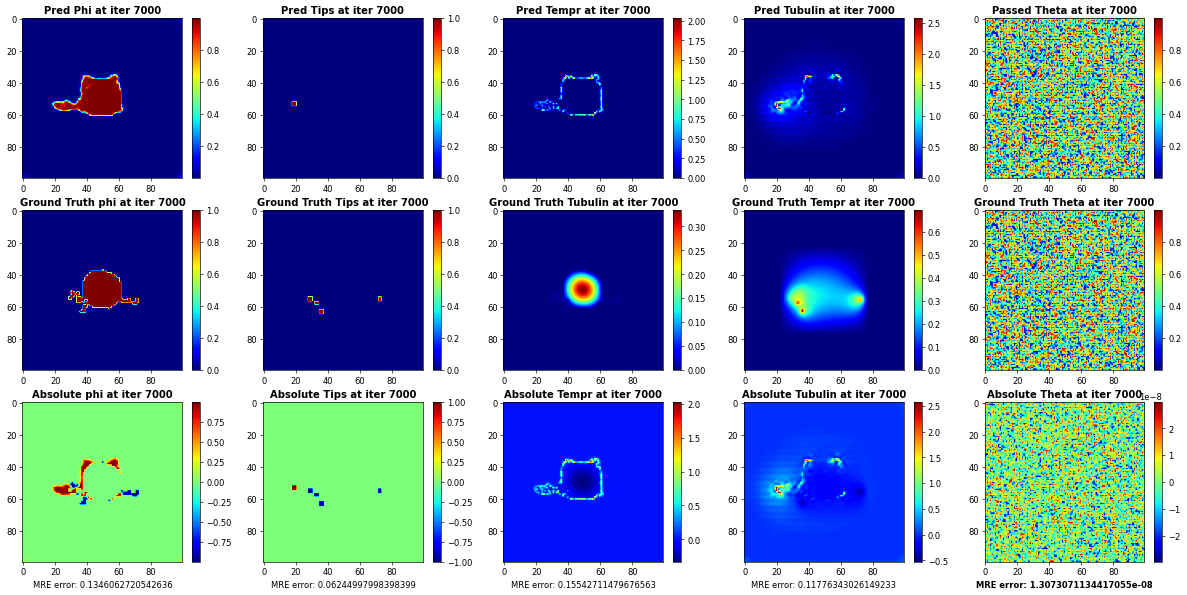

Plotting and Saving figures ...:  14%|█▍        | 9/64 [00:13<01:21,  1.49s/it]

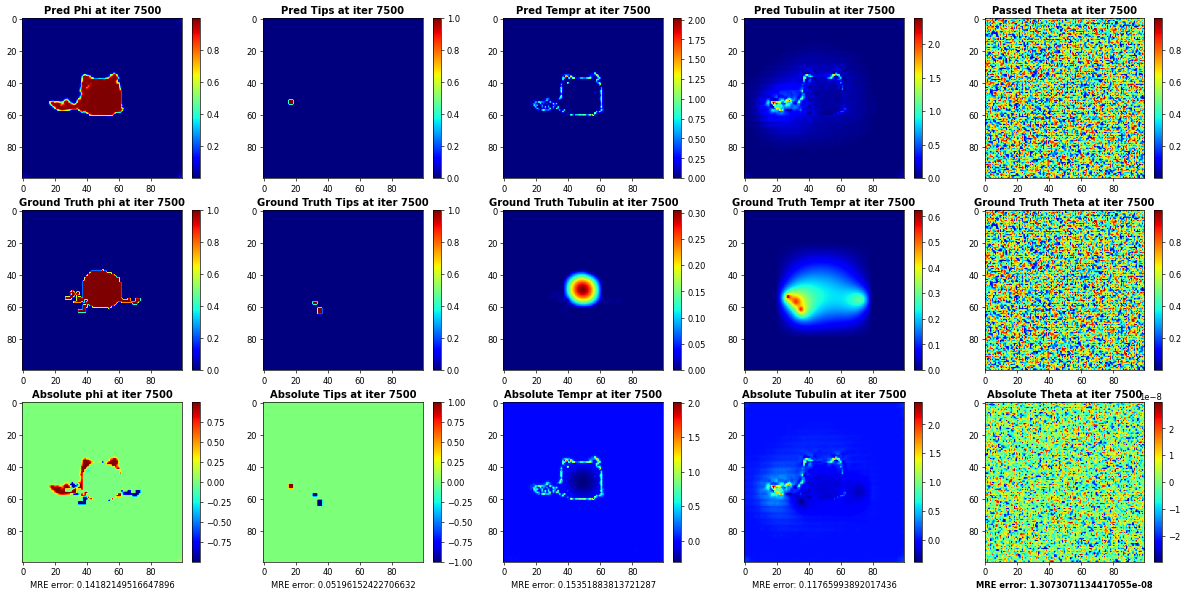

Plotting and Saving figures ...:  16%|█▌        | 10/64 [00:15<01:18,  1.45s/it]

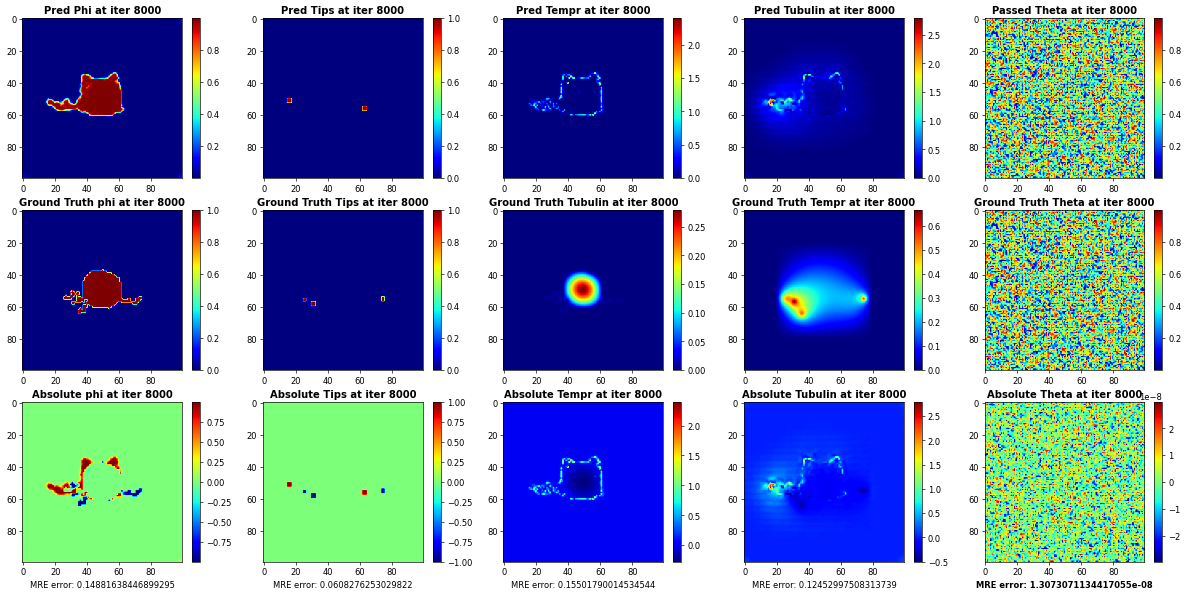

Plotting and Saving figures ...:  17%|█▋        | 11/64 [00:16<01:14,  1.40s/it]

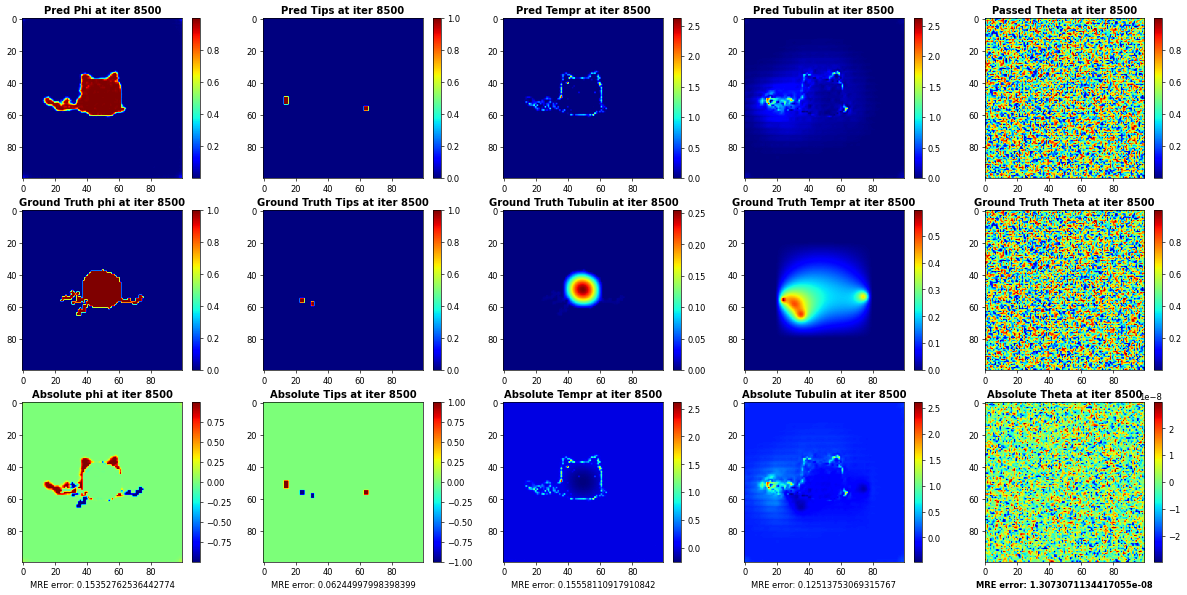

Plotting and Saving figures ...:  19%|█▉        | 12/64 [00:18<01:15,  1.46s/it]

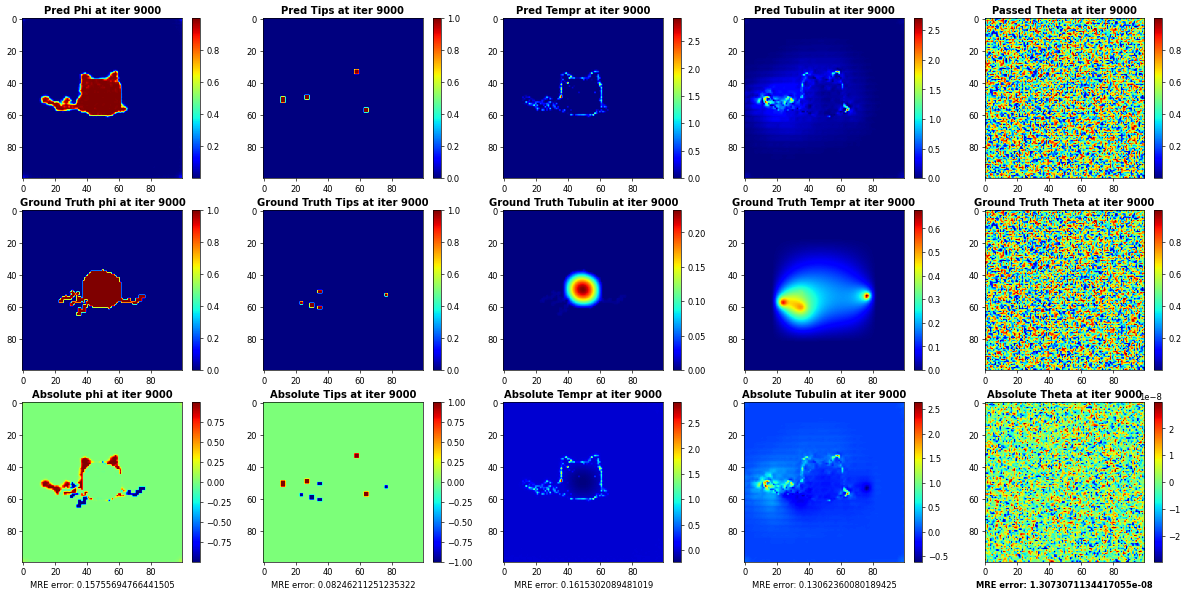

Plotting and Saving figures ...:  20%|██        | 13/64 [00:19<01:11,  1.41s/it]

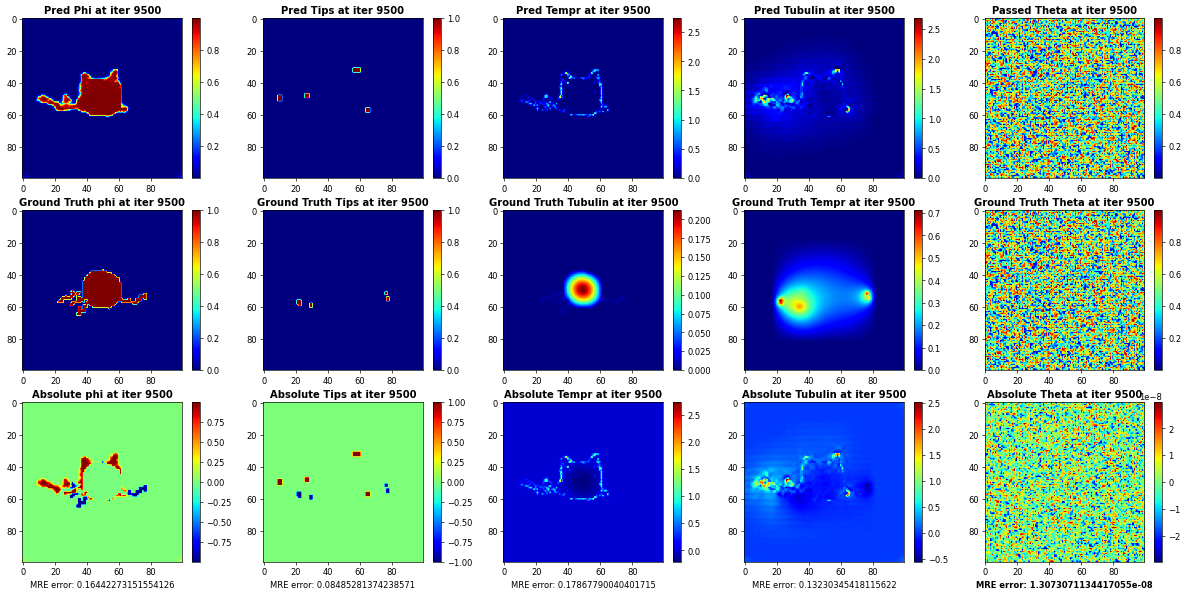

Plotting and Saving figures ...:  22%|██▏       | 14/64 [00:20<01:09,  1.39s/it]

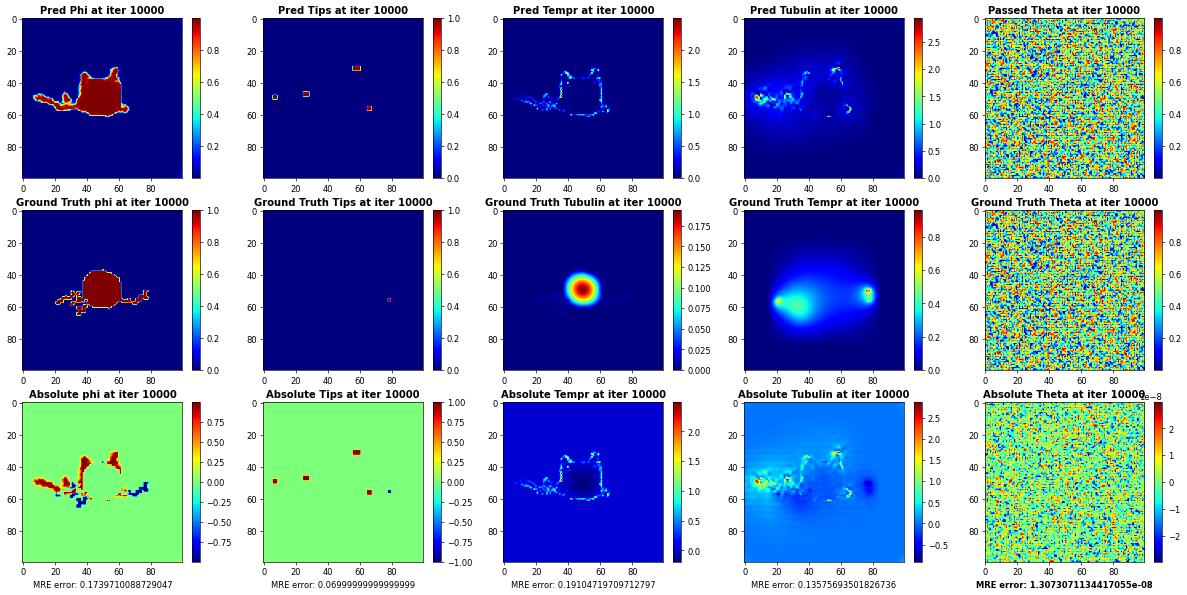

Plotting and Saving figures ...:  23%|██▎       | 15/64 [00:22<01:11,  1.45s/it]

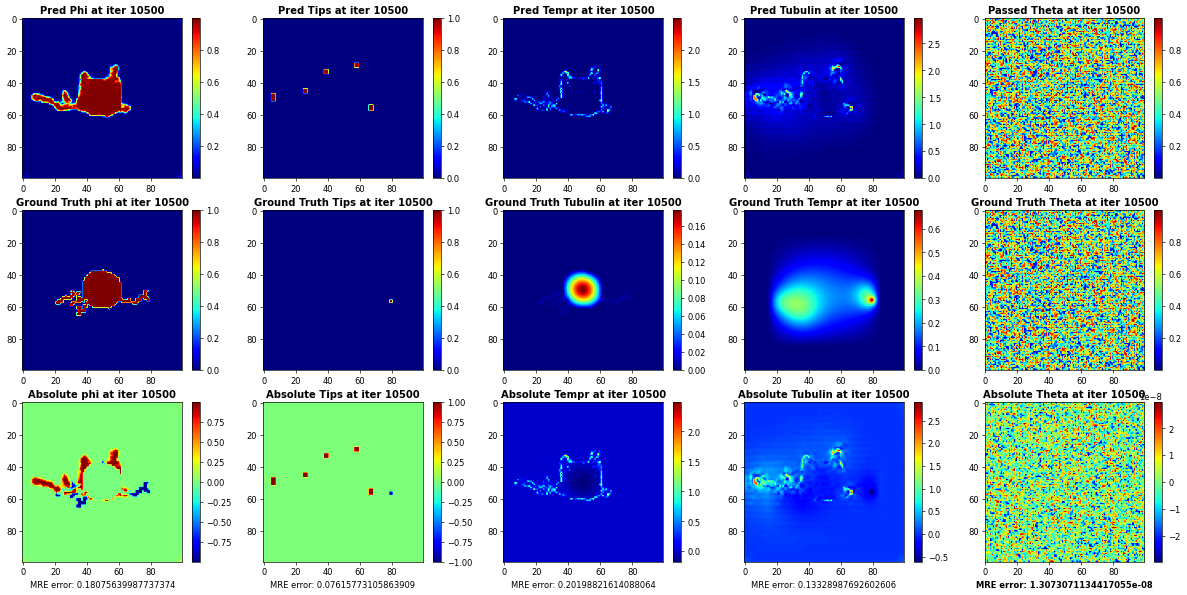

Plotting and Saving figures ...:  25%|██▌       | 16/64 [00:23<01:07,  1.41s/it]

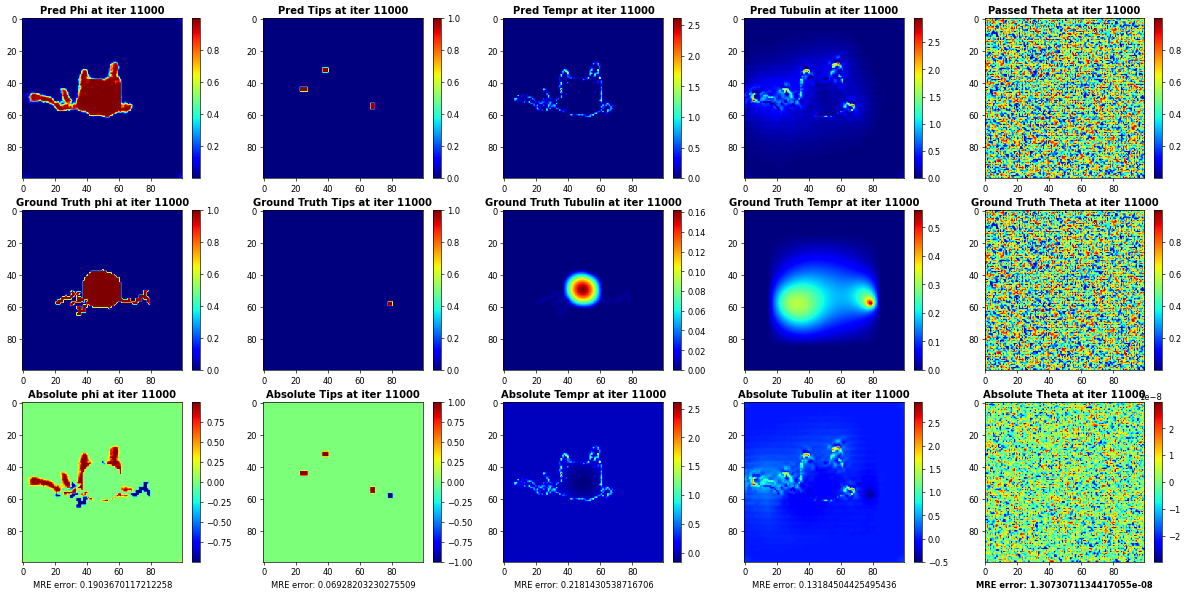

Plotting and Saving figures ...:  27%|██▋       | 17/64 [00:25<01:05,  1.39s/it]Arrays have incompatible sizes for this operation.

Error in highlightZone (line 16)
    theta = theta+ttt;    

Error in generate_tips_for_python (line 25)
    [theta_ori] = highlightZone(lenu,lenv,round(Max_x),round(Max_y),size_Max);

Plotting and Saving figures ...:  27%|██▋       | 17/64 [00:25<01:10,  1.50s/it]


MatlabExecutionError: 
  File /home/kuanrenqian/Documents/NeuronGrowthML/tensorflow_version/highlightZone.m, line 16, in highlightZone

  File /home/kuanrenqian/Documents/NeuronGrowthML/tensorflow_version/generate_tips_for_python.m, line 25, in generate_tips_for_python
Arrays have incompatible sizes for this operation.


In [15]:
import matlab.engine
import copy
eng = matlab.engine.start_matlab()

def push(input, cutoff):
    max_input = np.amax(input)
    output = copy.copy(input)
    output[input>cutoff*max_input] = 1
    output[input<=cutoff*max_input] = 0
    return output

def get_mre(pred,goal):
    return np.sqrt(np.sum(np.square(pred-goal)/(pred.shape[0]*pred.shape[1])))
    
rand_case = np.random.randint((len(val_dataset)))
example_x = val_dataset[rand_case,:,:,:,0:5]
example_theta = example_x[0,...,-1]
tmp_p_var = example_theta

x_in = np.expand_dims(example_x[0:5,...],axis=0)

for i in tqdm(range(64), desc="Plotting and Saving figures ..."):
    new_prediction = model.predict(x_in,verbose="0")
    phi = new_prediction[0,0,:,:,0]
    tips = np.round(eng.generate_tips_for_python(matlab.double(np.array(phi).astype('float64')),5000))
    # tips = push(new_prediction[0,0,:,:,1],0.5)
    tub = new_prediction[0,0,:,:,2]
    tempr = new_prediction[0,0,:,:,3]
    theta = new_prediction[0,0,:,:,4]

    iter = (i+1)*500+2500
    plt.figure(figsize=(25, 12), dpi=60)
    plt.gcf().set_facecolor("white")
    plt.subplot(3,5,1)
    plt.imshow(phi, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Phi at iter {iter}", fontweight='bold')
    plt.subplot(3,5,2)
    plt.imshow(tips, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,5,3)
    plt.imshow(tub, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tempr at iter {iter}", fontweight='bold')
    plt.subplot(3,5,4)
    plt.imshow(tempr, cmap='jet')
    plt.colorbar()
    plt.title(f"Pred Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,5,5)
    plt.imshow(theta, cmap='jet')
    plt.colorbar()
    plt.title(f"Passed Theta at iter {iter}", fontweight='bold')

    plt.subplot(3,5,6)
    plt.imshow(example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth phi at iter {iter}", fontweight='bold')
    plt.subplot(3,5,7)
    plt.imshow(example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tips at iter {iter}", fontweight='bold')
    plt.subplot(3,5,8)
    plt.imshow(example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tubulin at iter {iter}", fontweight='bold')
    plt.subplot(3,5,9)
    plt.imshow(example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Tempr at iter {iter}", fontweight='bold')
    plt.subplot(3,5,10)
    plt.imshow(example_x[i+5,:,:,4], cmap='jet')
    plt.colorbar()
    plt.title(f"Ground Truth Theta at iter {iter}", fontweight='bold')

    mre_phi = get_mre(phi,example_x[i+5,:,:,0])
    mre_tips = get_mre(tips,example_x[i+5,:,:,1])
    mre_tempr = get_mre(tempr,example_x[i+5,:,:,2])
    mre_tub = get_mre(tub,example_x[i+5,:,:,3])
    mre_theta = get_mre(theta,example_x[i+5,:,:,4])

    plt.subplot(3,5,11)
    plt.imshow(phi-example_x[i+5,:,:,0], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute phi at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_phi}")
    plt.subplot(3,5,12)
    plt.imshow(tips-example_x[i+5,:,:,1], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tips at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tips}")
    plt.subplot(3,5,13)
    plt.imshow(tub-example_x[i+5,:,:,2], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tempr at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tempr}")
    plt.subplot(3,5,14)
    plt.imshow(tempr-example_x[i+5,:,:,3], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Tubulin at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_tub}")
    plt.subplot(3,5,15)
    plt.imshow(theta-example_x[i+5,:,:,4], cmap='jet')
    plt.colorbar()
    plt.title(f"Absolute Theta at iter {iter}", fontweight='bold')
    plt.xlabel(f"MRE error: {mre_theta}", fontweight='bold')

    # plt.savefig(f"temp/gif/{iter:05d}.png")
    plt.show()

    tmp_var = copy.copy(new_prediction)
    tmp_var[0,-1,:,:,1] = tips
    tmp = np.zeros(x_in.shape)
    tmp[0,0,...] = x_in[0,1,...]
    tmp[0,1,...] = x_in[0,2,...]
    tmp[0,2,...] = x_in[0,3,...]
    tmp[0,3,...] = x_in[0,4,...]
    tmp[0,4,:,:,:] = tmp_var

    x_in = tmp